In [105]:
import sys
from datetime import datetime
import warnings
warnings.filterwarnings("ignore") 

# Snapping POIs

Following the approach proposed in [this blog post](https://towardsdatascience.com/connecting-pois-to-a-road-network-358a81447944) by Yuwen Chang, we can attach the POIs and centroids to the street networks as new nodes. The modified code is available in the src directory:

In [129]:
import numpy as np
import pandas as pd
import geopandas as gpd
import osmnx as ox

import rtree
import itertools

from shapely.geometry import MultiPoint, LineString
from shapely.ops import snap, split

pd.options.mode.chained_assignment = None

##########################################################################################

# Source code at https://github.com/ywnch/toolbox/blob/master/toolbox.py
# Yuwen Chang
# 2020-08-16

def connect_poi(pois, nodes, edges, key_col=None, path=None, threshold=200, knn=5, meter_epsg=5070):
    """Connect and integrate a set of POIs into an existing road network.
    Given a road network in the form of two GeoDataFrames: nodes and edges,
    link each POI to the nearest edge (road segment) based on its projection
    point (PP) and generate a new integrated road network including the POIs,
    the projected points, and the connection edge.
    Args:
        pois (GeoDataFrame): a gdf of POI (geom: Point)
        nodes (GeoDataFrame): a gdf of road network nodes (geom: Point)
        edges (GeoDataFrame): a gdf of road network edges (geom: LineString)
        key_col (str): a unique key column of pois should be provided,
                       e.g., 'index', 'osmid', 'poi_number', etc.
                       Currently, this will be renamed into 'osmid' in the output.
                       [NOTE] For use in pandana, you may want to ensure this
                              column is numeric-only to avoid processing errors.
                              Preferably use unique integers (int or str) only,
                              and be aware not to intersect with the node key,
                              'osmid' if you use OSM data, in the nodes gdf.
        path (str): directory path to use for saving files (nodes and edges).
                      Outputs will NOT be saved if this arg is not specified.
        threshold (int): the max length of a POI connection edge, POIs with
                         connection edge beyond this length will be removed.
                         The unit is in meters as crs epsg is set to 3857 by
                         default during processing.
        knn (int): k nearest neighbors to query for the nearest edge.
                   Consider increasing this number up to 10 if the connection
                   output is slightly unreasonable. But higher knn number will
                   slow down the process.
        meter_epsg (int): preferred EPSG in meter units. Suggested 3857 or 3395.
    Returns:
        nodes (GeoDataFrame): the original gdf with POIs and PPs appended
        edges (GeoDataFrame): the original gdf with connection edges appended
                              and existing edges updated (if PPs are present)
    Note:
        1. Make sure all three input GeoDataFrames have defined crs attribute.
           Try something like `gdf.crs` or `gdf.crs = 'epsg:4326'`.
           They will then be converted into epsg:3857 or specified meter_epsg for processing.
    """

    ## STAGE 0: initialization
    # 0-1: helper functions
    def find_kne(point, lines):
        dists = np.array(list(map(lambda l: l.distance(point), lines)))
        kne_pos = dists.argsort()[0]
        kne = lines.iloc[[kne_pos]]
        kne_idx = kne.index[0]
        return kne_idx, kne.values[0]

    def get_pp(point, line):
        """Get the projected point (pp) of 'point' on 'line'."""
        # project new Point to be interpolated
        pp = line.interpolate(line.project(point))  # PP as a Point
        return pp

    def split_line(line, pps):
        """Split 'line' by all intersecting 'pps' (as multipoint).
        Returns:
            new_lines (list): a list of all line segments after the split
        """
        # IMPORTANT FIX for ensuring intersection between splitters and the line
        # but no need for updating edges_meter manually because the old lines will be
        # replaced anyway
        line = snap(line, pps, 1e-8)  # slow?

        try:
            new_lines = list(split(line, pps))  # split into segments
            return new_lines
        except TypeError as e:
            print('Error when splitting line: {}\n{}\n{}\n'.format(e, line, pps))
            return []

    def update_nodes(nodes, new_points, ptype, meter_epsg=5070, _pois_gdf=None):
        """Update nodes with a list (pp) or a GeoDataFrame (poi) of new_points.
        
        Args:
            ptype: type of Point list to append, 'pp' or 'poi'
            pois_gdf: GeoDataFrame of POIS, if passed we will mark the assigned node id
        """
        # create gdf of new nodes (projected PAPs)
        if ptype == 'pp':
            new_nodes = gpd.GeoDataFrame(new_points, columns=['geometry'], crs=f'epsg:{meter_epsg}')
            n = len(new_nodes)
            new_nodes['highway'] = node_highway_pp
            new_nodes['osmid'] = [int(osmid_prefix + i) for i in range(n)]

        # create gdf of new nodes (original POIs)
        elif ptype == 'poi':
            new_nodes = new_points[['geometry']]
            new_nodes['highway'] = node_highway_poi
            new_nodes['osmid'] = [int(osmid_prefix + i) for i in range(n)]

        else:
            print("Unknown ptype when updating nodes.")
            
        if _pois_gdf is not None:
            _pois_gdf['access_node'] = new_nodes['osmid'].values

        # merge new nodes (it is safe to ignore the index for nodes)
        gdfs = [nodes, new_nodes]
        nodes = gpd.GeoDataFrame(pd.concat(gdfs, ignore_index=True, sort=False),
                                 crs=gdfs[0].crs)
        if _pois_gdf is not None:
            return nodes, new_nodes, _pois_gdf  # all nodes, newly added nodes only, POI-osmid mapping
        
        else:
            return nodes, new_nodes  # all nodes, newly added nodes only

    def update_edges(edges, new_lines, replace=True):
        """
        Update edge info by adding new_lines; or,
        replace existing ones with new_lines (n-split segments).
        Args:
            replace: treat new_lines (flat list) as newly added edges if False,
                     else replace existing edges with new_lines (often a nested list)
        
        Note:
            kne_idx refers to 'fid in Rtree'/'label'/'loc', not positional iloc
        """
        # for interpolation (split by pp): replicate old line
        if replace:
            # create a flattened gdf with all line segs and corresponding kne_idx
            kne_idxs = list(line_pps_dict.keys())
            lens = [len(item) for item in new_lines]
            new_lines_gdf = gpd.GeoDataFrame({'kne_idx': np.repeat(kne_idxs, lens), 'geometry': list(itertools.chain.from_iterable(new_lines))})
            # merge to inherit the data of the replaced line
            cols = list(edges.columns)
            cols.remove('geometry')  # don't include the old geometry
            new_edges = new_lines_gdf.merge(edges[cols], how='left', left_on='kne_idx', right_index=True)
            new_edges.drop('kne_idx', axis=1, inplace=True)
            new_lines = new_edges['geometry'].values  # now a flatten list
        # for connection (to external poi): append new lines
        else:
            new_edges = gpd.GeoDataFrame(pois.index.values, geometry=new_lines)
            new_edges['oneway'] = False
            new_edges['highway'] = edge_highway

        # update features (a bit slow)
        new_edges['length'] = [l.length for l in new_lines]
        new_edges['from'] = new_edges['geometry'].map(lambda x: nodes_id_dict.get(list(x.coords)[0], None))
        new_edges['to'] = new_edges['geometry'].map(lambda x: nodes_id_dict.get(list(x.coords)[-1], None))
        new_edges['osmid'] = ['_'.join(list(map(str, s))) for s in zip(new_edges['from'], new_edges['to'])]

        # remember to reindex to prevent duplication when concat
        start = edges.index[-1] + 1
        stop = start + len(new_edges)
        new_edges.index = range(start, stop)

        # for interpolation: remove existing edges
        if replace:
            edges = edges.drop(kne_idxs, axis=0)
        # for connection: filter invalid links
        else:
            valid_pos = np.where(new_edges['length'] <= threshold)[0]
            n = len(new_edges)
            n_fault = n - len(valid_pos)
            f_pct = n_fault / n * 100
            print("Remove faulty projections: {}/{} ({:.2f}%)".format(n_fault, n, f_pct))
            new_edges = new_edges.iloc[valid_pos]  # use 'iloc' here

        # merge new edges
        dfs = [edges, new_edges]
        edges = gpd.GeoDataFrame(pd.concat(dfs, ignore_index=False, sort=False), crs=dfs[0].crs)

        # all edges, newly added edges only
        return edges, new_edges

    # 0-2: configurations
    # set poi arguments
    node_highway_pp = 'projected_pap'  # POI Access Point
    node_highway_poi = 'poi'
    edge_highway = 'projected_footway'
    osmid_prefix = int(nodes.osmid.max()) + 1

    # convert CRS
    pois_meter = pois.to_crs(epsg=meter_epsg)
    nodes_meter = nodes.to_crs(epsg=meter_epsg)
    edges_meter = edges.to_crs(epsg=meter_epsg)

    # build rtree
    print("Building rtree...")
    Rtree = rtree.index.Index()
    [Rtree.insert(fid, geom.bounds) for fid, geom in edges_meter['geometry'].iteritems()]

    ## STAGE 1: interpolation
    # 1-1: assign external node IDs (pois)
    #print("Assigning external nodes...")
    #nodes_meter, _new_nodes, poi_keys = update_nodes(nodes_meter, pois_meter, ptype='poi', meter_epsg=meter_epsg, key_col='safegraph_place_id')
    
    # 1-2: update internal nodes (interpolated pps)
    # locate nearest edge (kne) and projected point (pp)
    print("Projecting POIs to the network...")
    pois_meter['near_idx'] = [list(Rtree.nearest(point.bounds, knn))
                              for point in pois_meter['geometry']]  # slow
    
    pois_meter['near_lines'] = [edges_meter['geometry'][near_idx]
                                for near_idx in pois_meter['near_idx']]  # very slow
    pois_meter['kne_idx'], knes = zip(*[find_kne(point, near_lines) for point, near_lines in zip(pois_meter['geometry'], pois_meter['near_lines'])])  # slow
    pois_meter['pp'] = [get_pp(point, kne) for point, kne in zip(pois_meter['geometry'], knes)]

    # update nodes
    print("Assigning nodes to POIs and updating...")
    nodes_meter, new_nodes_meter, pois_meter = update_nodes(nodes_meter, list(pois_meter['pp']), ptype='pp', meter_epsg=meter_epsg, _pois_gdf=pois_meter)
    nodes_coord = nodes_meter['geometry'].map(lambda x: x.coords[0])
    nodes_id_dict = dict(zip(nodes_coord, nodes_meter['osmid'].astype('Int64')))

    # 1-3: update internal edges (split line segments)
    print("Updating internal edges...")
    # split
    line_pps_dict = {k: MultiPoint(list(v)) for k, v in pois_meter.groupby(['kne_idx'])['pp']}
    new_lines = [split_line(edges_meter['geometry'][idx], pps) for idx, pps in line_pps_dict.items()]  # bit slow
    edges_meter, _ = update_edges(edges_meter, new_lines, replace=True)

    ## STAGE 2: connection
    # 2-1: add external distances (projected footways connected to pois) to the POIs
    print("Adding external distance...")
    pps_gdf = nodes_meter[nodes_meter['highway'] == node_highway_pp]
    new_lines = [LineString([p1, p2]) for p1, p2 in zip(pois_meter['geometry'], pps_gdf['geometry'])]
    pois_meter['access_distance'] = [l.length for l in new_lines]
    #edges_meter, _ = update_edges(edges_meter, new_lines, replace=False)

    ## STAGE 3: output
    # convert CRS
    nodes = nodes_meter.to_crs(epsg=4326)
    edges = edges_meter.to_crs(epsg=4326)

    # preprocess for pandana
    nodes.index = nodes['osmid']  # IMPORTANT
    nodes['x'] = [p.x for p in nodes['geometry']]
    nodes['y'] = [p.y for p in nodes['geometry']]

    # edges.reset_index(drop=True, inplace=True)
    edges['length'] = edges['length'].astype(float)

    # report issues
    # - examine key duplication
    if len(nodes_meter) != len(nodes_id_dict):
        print("NOTE: duplication in node coordinates keys")
        print("Nodes count:", len(nodes_meter))
        print("Node coordinates key count:", len(nodes_id_dict))
    # - examine missing nodes
    print("Missing 'from' nodes:", len(edges[edges['from'] == None]))
    print("Missing 'to' nodes:", len(edges[edges['to'] == None]))

    # save and return
    if path:
        nodes.to_file(path+'/nodes.shp')
        edges.to_file(path+'/edges.shp')
        

    return nodes, edges, pois_meter

The following functions do our algorithm to compute distances:

In [3]:
#Defining input directories:
fua_buffered_shapefile_dir = '../data/d03_intermediate/FUA-buffered-shapefile/'
full_od_matrix_dir = '../data/d02_processed-safegraph/'
networks_dir = '../data/d03_intermediate/FUA-networks/'

In [4]:
def get_boundary(fua_code):
    return gpd.read_file(fua_buffered_shapefile_dir + 'FUA-buffered.shp').set_index('fuacode').loc[[fua_code]]

def get_fua_ODmatrix(fua_code, split_in_half=split):
    full_od_matrix = pd.read_csv(full_od_matrix_dir + 'weeks_od_us_fua.csv')
    fua_raw_od_matrix = full_od_matrix[full_od_matrix.fuacode==fua_code].reset_index(drop=True)
    fua_raw_od_matrix['fuacode'] = fua_code
    
    if split_in_half == 1:
        return fua_raw_od_matrix[:len(fua_raw_od_matrix)//2].reset_index(drop=True)
    elif split_in_half == 2:
        return fua_raw_od_matrix[len(fua_raw_od_matrix)//2:].reset_index(drop=True)
    else:
        return fua_raw_od_matrix

def load_graphs(fua_code, proj_crs='EPSG:5070'):
    walk_graph = ox.project_graph(ox.load_graphml(networks_dir + 'walk/'+fua_code+'.graphml'), to_crs=proj_crs)
    drive_graph = ox.project_graph(ox.load_graphml(networks_dir + 'drive/'+fua_code+'.graphml'), to_crs=proj_crs)
    
    return walk_graph, drive_graph

def trim_centroids(od_matrix, buffered_boundary, bdry_as_gdf=True):
    
    if bdry_as_gdf:
        buffered_boundary = buffered_boundary.geometry[0]
    
    centroids_pt = gpd.points_from_xy(x= od_matrix.intptlon, y=od_matrix.intptlat, crs='EPSG:4326')
    rows_to_keep = centroids_pt.within(buffered_boundary)
    trimmed_od_matrix = od_matrix[rows_to_keep].reset_index(drop=True)
    
    print('.   total of', len(trimmed_od_matrix), ' rows')

    return trimmed_od_matrix

Let's test it for a few rows. First we load the data:

In [5]:
fua_code = 'USA80'
start = datetime.now()

#1. LOAD ALL THE FILES:
fua_buffered_boundary = get_boundary(fua_code) #get the FUA boundary
fua_raw_od_matrix = get_fua_ODmatrix(fua_code) #get the commutes within that FUA
fua_od_matrix = trim_centroids(fua_raw_od_matrix, fua_buffered_boundary) #exclude far away centroids
walk_graph, drive_graph = load_graphs(fua_code) #get the graphs

loading_complete=datetime.now()
print(' Loaded all files in:', loading_complete-start)

.   total of 61536  rows
 Loaded all files in: 0:03:49.712744


Now we get the gdfs from the graph and clean them with momepy:

In [97]:
nodes_walk_ind, edges_walk_multi = ox.utils_graph.graph_to_gdfs(walk_graph)
nodes_walk = nodes_walk_ind.reset_index()
edges_walk = edges_walk_multi.reset_index()

nodes, edges = momepy.nx_to_gdf(momepy.gdf_to_nx(edges_walk.explode(index_parts=True)))
edges = edges[['node_start', 'node_end', 'mm_len', 'geometry']].rename({'node_start':'from', 'node_end':'to',
                                                                        'mm_len':'length'}, axis=1)
nodes = nodes.rename({'nodeID':'osmid'}, axis=1)

From the OD matrix we must extract the list of unique POIs which we want to attach to the network.

In [99]:
start = datetime.now()

pois_pt = gpd.points_from_xy(x=fua_od_matrix.longitude, y=fua_od_matrix.latitude, crs='EPSG:4326')
pois_gdf = gpd.GeoDataFrame(fua_od_matrix[['safegraph_place_id']], geometry=pois_pt)
pois_gdf.drop_duplicates(subset='safegraph_place_id', keep='first', inplace=True)
pois_gdf = pois_gdf.set_index('safegraph_place_id')

georeferencing_complete=datetime.now()
print(' Georeferenced POIs in:', georeferencing_complete-start)

 Georeferenced POIs in: 0:00:02.282601


The POIs will be attached to the closest edge. The following function expands given node and edge geodataframes with the POIs, and records in the fua_od_matrix the corresponding destination node osmid and length of footway from the road to the POI

In [130]:
start = datetime.now()

exp_nodes_walk, exp_edges_walk, pois_with_access_walk = connect_poi(pois_gdf, nodes, edges)

connection_complete=datetime.now()
print(' Connected POIs to walking network in:', connection_complete-start)

Building rtree...
Projecting POIs to the network...
Assigning nodes to POIs and updating...
Updating internal edges...
Adding external distance...
NOTE: duplication in node coordinates keys
Nodes count: 172404
Node coordinates key count: 172149
Missing 'from' nodes: 0
Missing 'to' nodes: 0
 Connected POIs to walking network in: 0:02:02.957706


Now we can do the distance computation. Since we have gdfs, we will use pandana:

In [131]:
import pandana

We can rebuild the street network from the gdfs in Pandana:

In [132]:
expanded_walk_graph = pandana.Network(exp_nodes_walk.geometry.x, exp_nodes_walk.geometry.y,
                                      exp_edges_walk['from'], exp_edges_walk['to'],
                                      edge_weights=exp_edges_walk[['length']])

Generating contraction hierarchies with 4 threads.
Setting CH node vector of size 172404
Setting CH edge vector of size 466494
Range graph removed 471726 edges of 932988
. 10% . 20% . 30% . 40% . 50% . 60% . 70% . 80% . 90% . 100%


Now we can prepare the FUA matrix with the respective access nodes. Recall that, for the centroids of the CBGs, we can simply get the nearest OSM node.

In [133]:
start = datetime.now()

cbgs_pt = gpd.points_from_xy(x=fua_od_matrix.intptlon, y=fua_od_matrix.intptlat, crs='EPSG:4326')
cbgs_x, cbgs_y = cbgs_pt.x, cbgs_pt.y
fua_od_matrix['origin_node'] = expanded_walk_graph.get_node_ids(cbgs_x, cbgs_y)

fua_od_matrix_with_nodes = fua_od_matrix.merge(pois_with_access_walk[['access_node', 'access_distance']], how='left', left_on='safegraph_place_id', right_index=True)

origins_complete=datetime.now()
print(' Found OD nodes in:', origins_complete-start)

 Found OD nodes in: 0:00:03.726223


Now we can compute the distance:

In [134]:
start = datetime.now()

fua_od_matrix_with_nodes['shortest_distance'] = expanded_walk_graph.shortest_path_lengths(fua_od_matrix_with_nodes.origin_node.values,
                                                                                          fua_od_matrix_with_nodes.access_node.values,
                                                                                          imp_name='length')

distances_complete=datetime.now()
print(' Found distances in:', distances_complete-start)

 Found distances in: 0:00:00.766985


There are some results with suspiciously high distances. We can check that on a histogram of the log distance (so a log-distance around 3-4 would mean people would walk 1-10km)

Text(0.5, 1.0, 'USA80')

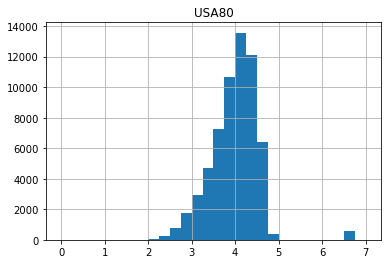

In [135]:
import matplotlib.pyplot as plt

log_dists = fua_od_matrix_with_nodes.shortest_distance.apply(np.log10)
log_dists.hist(bins=4*int(log_dists.max()+1), range=(0, int(log_dists.max())+1))
plt.title(fua_code)

We notice the very few distances on the order of 10 to the 6. Investigating those:

In [136]:
outlier_rows = fua_od_matrix_with_nodes[fua_od_matrix_with_nodes.shortest_distance > 10**5].reset_index(drop=True)
print('There are ', len(outlier_rows), 'bad rows, which accounts for {:.2%} of total'.format(len(outlier_rows)/len(fua_od_matrix_with_nodes)))

There are  603 bad rows, which accounts for 0.98% of total


Notice that they are all the same distance!

In [137]:
set(outlier_rows.shortest_distance.values)

{4294967.295}

Let's check these routes:

In [125]:
bad_origins = outlier_rows.origin_node.values
bad_destinations = outlier_rows.access_node.values
bad_routes = expanded_walk_graph.shortest_paths(bad_origins, bad_destinations,imp_name='length')

Turns out they are all empty:

In [139]:
for route in bad_routes:
    if len(route) > 0:
        print(route)

So for a few OD pairs we could not find a root (i.e. the graph was nto connected).

In [158]:
bad_nodes = list(set(np.hstack([bad_origins, bad_destinations])))

bad_nodes_df = exp_nodes_walk[[]]
bad_nodes_df['bad'] = 0

bad_nodes_df.loc[bad_nodes, 'bad'] = 1

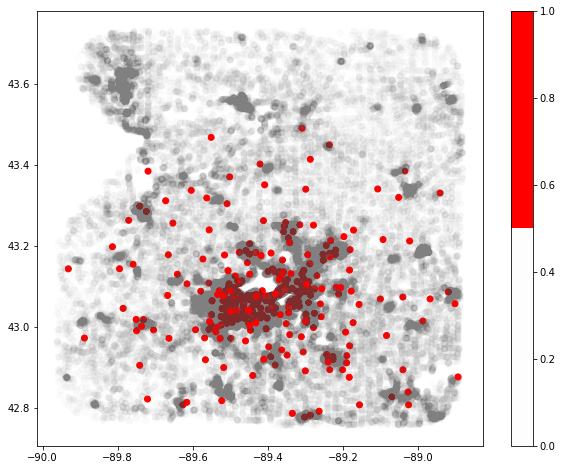

(<Figure size 720x576 with 2 Axes>, <AxesSubplot:>)

In [175]:
from matplotlib.colors import ListedColormap

# Color for False and True
cmap = ListedColormap(['gray', 'red'])

my_cmap = cmap(np.arange(cmap.N))
my_cmap[:,-1] = [0.01, 1]
cmap = ListedColormap(my_cmap)

expanded_walk_graph.plot(bad_nodes_df, plot_kwargs={'cmap':cmap})

Let's print the summary for more cities: